In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Swamp sparrow vocalizations
Source:
- https://figshare.com/articles/SwampSparrow_luscdb_zip/5625310
- https://www.nature.com/articles/s41467-018-04728-1

In [2]:
from pathlib2 import Path
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import numpy as np

In [3]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
DSLOC = Path('/mnt/cube/Datasets/swampsparrow/') / 'swampsparrow-xml'

In [5]:
DSLOC / 'SYLLABLE.csv'

PosixPath('/mnt/cube/Datasets/swampsparrow/swampsparrow-xml/SYLLABLE.csv')

### Load data

In [6]:
individual = pd.read_csv(DSLOC / 'INDIVIDUAL.csv')
individual[:3]

,ID,NUMSONGS,NAME,SPECID,POPID,LOCDESC,GRIDTYPE,GRIDX,GRIDY,SEX,RANK,AGE
0,48,NaN,MIWAT01,Swamp Sparrow,"Waterloo, MI",NaN,UTM,42.360523,-84.1779184,NaN,NaN,NaN
1,49,NaN,MIWAT02,Swamp Sparrow,"Waterloo, MI",NaN,UTM,42.360924,-84.1781069,NaN,NaN,NaN
2,50,NaN,MIWAT03,Swamp Sparrow,"Waterloo, MI",,UTM,42.360829,-84.1782932,NaN,NaN,NaN


In [7]:
syllables = pd.read_csv(DSLOC / 'SYLLABLE.csv')
syllables[:3]

,SONGID,STARTTIME,ENDTIME
0,2531,1220,1536
1,2531,1223,1297
2,2531,1306,1378


In [8]:
elements = pd.read_csv(DSLOC / 'ELEMENT.csv')
elements[:3]

,ID,SONGID,SIGNAL,PEAKFREQ,FUNDFREQ,MEANFREQ,MEDIANFREQ,PEAKFREQCHANGE,FUNDFREQCHANGE,MEANFREQCHANGE,...,GAPAFTER,TIMESTEP,FRAMELENGTH,MAXF,WINDOWMETHOD,DY,DYNRANGE,DYNCOMP,ECHORANGE,ECHOCOMP
0,1820682,2011,3 177 145 139 3 178 146 137 3 179 146 137 3 18...,4263.57421875 3832.91015625 15.0 0.0 4062.5976...,4283.673733543762 3815.8396713317325 19.0 0.0 ...,4270.3427222250075 3826.5109432227587 19.0 0.0...,4306.266418097342 3843.9194083976013 14.0 3.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,...,7.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0
1,1820683,2011,3 230 60 57 3 231 63 57 3 232 64 57 3 233 66 5...,7407.421875 3100.78125 0.0 42.0 4587.030418882...,7389.1988844382295 3027.87251546893 0.0 42.5 4...,7409.13028952881 3048.31062821831 0.0 43.0 455...,7426.946155956237 3060.4056743941146 0.0 44.0 ...,-0.012553735012542117 -0.03338982031684048 28....,-0.012553735012542117 -0.03338982031684048 28....,-0.012553735012542117 -0.03338982031684048 28....,...,2.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0
2,1820684,2011,5 328 115 111 103 102 3 329 126 101 3 330 134 ...,4995.703125 3316.11328125 0.0 4.5 4117.1484375...,5137.39993108298 3399.0993019123976 0.0 4.0 42...,5047.68551414882 3327.0782209257077 0.0 4.5 41...,5064.723596006633 3325.6770996024384 0.0 4.5 4...,-0.12936507276325204 -0.12951987178017654 0.0 ...,-0.12936507276325204 -0.12951987178017654 0.0 ...,-0.12936507276325204 -0.12951987178017654 0.0 ...,...,28.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0


In [9]:
len(elements)

97613

In [10]:
elements.columns

Index(['ID', 'SONGID', 'SIGNAL', 'PEAKFREQ', 'FUNDFREQ', 'MEANFREQ',
       'MEDIANFREQ', 'PEAKFREQCHANGE', 'FUNDFREQCHANGE', 'MEANFREQCHANGE',
       'MEDIANFREQCHANGE', 'HARMONICITY', 'WIENER', 'BANDWIDTH', 'AMPLITUDE',
       'REVERBERATION', 'TRILLAMP', 'TRILLRATE', 'POWERSPECTRUM', 'STARTTIME',
       'OVERALLPEAKFREQ1', 'OVERALLPEAKFREQ2', 'TIMELENGTH', 'GAPBEFORE',
       'GAPAFTER', 'TIMESTEP', 'FRAMELENGTH', 'MAXF', 'WINDOWMETHOD', 'DY',
       'DYNRANGE', 'DYNCOMP', 'ECHORANGE', 'ECHOCOMP'],
      dtype='object')

In [11]:
songdata = pd.read_csv(DSLOC / 'SONGDATA.csv')
songdata[:3]

,ID,INDIVIDUALID,NAME,ECHOCOMP,ECHORANGE,DYNCOMP,DYNRANGE,MAXFREQ,FRAMELENGTH,TIMESTEP,...,RECORDINGEQUIPMENT,RECORDER,NOISE1,NOISE2,NOISE3,TIME,QUALITY,TYPE,CUSTOM0,CUSTOM1
0,2193,561,TypeS-CentroidA-C2.wav,1.0,50,40.0,200,10000,5.0,0.5,...,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1301475691000,,,NaN,NaN
1,2011,251,SWSP09HVTIV29K1.wav,1.0,50,40.0,200,10000,5.0,0.5,...,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1259216618000,,,NaN,NaN
2,2010,251,SWSP09HVTIV29GG1.wav,1.0,50,40.0,200,10000,5.0,0.5,...,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1259216653000,,,NaN,NaN


In [12]:
len(songdata)

1870

In [13]:
len(np.unique(songdata.INDIVIDUALID.values))

616

In [14]:
wavs = pd.read_csv(DSLOC / 'WAVS.csv')

In [15]:
wavs[:3]

,ID,SONGID,FILENAME,WAV,SAMPLERATE,FRAMESIZE,STEREO,BIGEND,SIGNED,SSIZEINBITS,TIME
0,71,71,PymConneaut08T50C-Z.wav,ebffe8ffdbffe3ffdfffddffe2ffdfffe3ffc8ffc4ffcd...,44100.0,2,1,0,1,16,1222840401000
1,72,72,PymConneaut08T42B-RA,c7ffb3ffc6ffd7ffd8fff8fffbff0400eaffdeffc2ffa8...,44100.0,2,1,0,1,16,1222837577000
2,73,73,PymConneaut08T42A-A.wav,e7ffe9fff0fffcfff6fff3fffffff2ffeeffebffe2fffa...,44100.0,2,1,0,1,16,1222837530000


In [16]:
wavs[wavs.FILENAME.values == 'SWSP09WATPO2C1.wav']

,ID,SONGID,FILENAME,WAV,SAMPLERATE,FRAMESIZE,STEREO,BIGEND,SIGNED,SSIZEINBITS,TIME
1447,1590,1590,SWSP09WATPO2C1.wav,d2ffd0ffdcffd2ffe4ffdcffdbffdfffd2ffd5ffd6ffd4...,44100.0,2,1,0,1,16,1245110195000


In [17]:
songdata[songdata.NAME == 'SWSP09WATPO2C1.wav']

,ID,INDIVIDUALID,NAME,ECHOCOMP,ECHORANGE,DYNCOMP,DYNRANGE,MAXFREQ,FRAMELENGTH,TIMESTEP,...,RECORDINGEQUIPMENT,RECORDER,NOISE1,NOISE2,NOISE3,TIME,QUALITY,TYPE,CUSTOM0,CUSTOM1
422,1590,49,SWSP09WATPO2C1.wav,1.0,50,40.0,200,10000,5.0,0.5,...,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1245110195000,,,NaN,NaN


In [18]:
import datetime
recording_time = datetime.datetime.fromtimestamp(1245110195000/1000.).strftime('%Y-%m-%d %H:%M:%S')
recording_time

'2009-06-15 16:56:35'

In [19]:
import struct
def string2int16(string):
    byte_array = bytes.fromhex(string)
    count = int(len(byte_array)/2)
    return struct.unpack("h"*count, byte_array)

In [20]:
# load the wav
rate, data = load_wav('SWSP09WATPO1B1.wav')
wavs[wavs.FILENAME.values == 'SWSP09WATPO1B1.wav']
wav_varbinary = wavs[wavs.FILENAME.values == 'SWSP09WATPO1B1.wav'].WAV.values[0]
data_from_binary = string2int16(wav_varbinary)

In [21]:
data[:5], data_from_binary[:5]

(array([-1, -3,  3, 26, 11], dtype=int16), (-1, -3, 3, 26, 11))

### Plot syllables by ID

In [22]:
songdata.columns.values

array(['ID', 'INDIVIDUALID', 'NAME', 'ECHOCOMP', 'ECHORANGE', 'DYNCOMP',
       'DYNRANGE', 'MAXFREQ', 'FRAMELENGTH', 'TIMESTEP', 'FILTERCUTOFF',
       'WINDOWMETHOD', 'DX', 'DY', 'SAMPLERATE', 'USER', 'CALL_LOCATION',
       'CALL_CONTEXT', 'RECORDINGEQUIPMENT', 'RECORDER', 'NOISE1',
       'NOISE2', 'NOISE3', 'TIME', 'QUALITY', 'TYPE', 'CUSTOM0',
       'CUSTOM1'], dtype=object)

In [23]:
songdata[:1]

,ID,INDIVIDUALID,NAME,ECHOCOMP,ECHORANGE,DYNCOMP,DYNRANGE,MAXFREQ,FRAMELENGTH,TIMESTEP,...,RECORDINGEQUIPMENT,RECORDER,NOISE1,NOISE2,NOISE3,TIME,QUALITY,TYPE,CUSTOM0,CUSTOM1
0,2193,561,TypeS-CentroidA-C2.wav,1.0,50,40.0,200,10000,5.0,0.5,...,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1301475691000,,,NaN,NaN


In [24]:
wavs[:1]

,ID,SONGID,FILENAME,WAV,SAMPLERATE,FRAMESIZE,STEREO,BIGEND,SIGNED,SSIZEINBITS,TIME
0,71,71,PymConneaut08T50C-Z.wav,ebffe8ffdbffe3ffdfffddffe2ffdfffe3ffc8ffc4ffcd...,44100.0,2,1,0,1,16,1222840401000


In [25]:
elements[:1]

,ID,SONGID,SIGNAL,PEAKFREQ,FUNDFREQ,MEANFREQ,MEDIANFREQ,PEAKFREQCHANGE,FUNDFREQCHANGE,MEANFREQCHANGE,...,GAPAFTER,TIMESTEP,FRAMELENGTH,MAXF,WINDOWMETHOD,DY,DYNRANGE,DYNCOMP,ECHORANGE,ECHOCOMP
0,1820682,2011,3 177 145 139 3 178 146 137 3 179 146 137 3 18...,4263.57421875 3832.91015625 15.0 0.0 4062.5976...,4283.673733543762 3815.8396713317325 19.0 0.0 ...,4270.3427222250075 3826.5109432227587 19.0 0.0...,4306.266418097342 3843.9194083976013 14.0 3.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,...,7.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0


In [26]:
individual[:1]

,ID,NUMSONGS,NAME,SPECID,POPID,LOCDESC,GRIDTYPE,GRIDX,GRIDY,SEX,RANK,AGE
0,48,NaN,MIWAT01,Swamp Sparrow,"Waterloo, MI",NaN,UTM,42.360523,-84.1779184,NaN,NaN,NaN


In [27]:
individual.POPID.unique()

array(['Waterloo, MI', 'Adirondacks, NY', 'Hudson Valley, NY',
       'Montezuma, NY', 'Conneaut, PA', 'Horicon, WI', nan], dtype=object)

### get waveforms of individual elements + INDIVIDUAL ID + POP ID + time

In [28]:
# indv, date

In [29]:
def process_swampsparrow_call(row):
    return

In [30]:
for idx, row in wavs.iterrows():
    if idx == 2: break
    #break

In [31]:
wavdata = string2int16(row.WAV)

In [32]:
row

ID                                                            73
SONGID                                                        73
FILENAME                                 PymConneaut08T42A-A.wav
WAV            e7ffe9fff0fffcfff6fff3fffffff2ffeeffebffe2fffa...
SAMPLERATE                                                 44100
FRAMESIZE                                                      2
STEREO                                                         1
BIGEND                                                         0
SIGNED                                                         1
SSIZEINBITS                                                   16
TIME                                               1222837530000
Name: 2, dtype: object

In [33]:
len(wavdata), len(wavdata)/row.SAMPLERATE

(106281, 2.41)

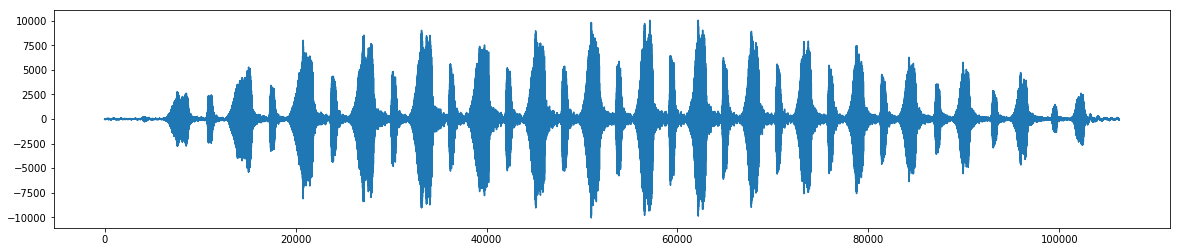

In [34]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(wavdata)
IPython.display.Audio(data=wavdata, rate=row.SAMPLERATE)

In [35]:
wav_elements = elements[elements.SONGID == row.SONGID]
wav_elements[:1]

,ID,SONGID,SIGNAL,PEAKFREQ,FUNDFREQ,MEANFREQ,MEDIANFREQ,PEAKFREQCHANGE,FUNDFREQCHANGE,MEANFREQCHANGE,...,GAPAFTER,TIMESTEP,FRAMELENGTH,MAXF,WINDOWMETHOD,DY,DYNRANGE,DYNCOMP,ECHORANGE,ECHOCOMP
97487,1918676,73,3 176 88 72 3 177 93 73 3 178 98 75 3 179 102 ...,6503.02734375 4177.44140625 0.0 11.5 5209.2407...,6474.346051351946 4213.482596193256 0.0 11.5 5...,6470.337267947049 4244.4360573487165 0.0 11.5 ...,6471.524629728496 4223.711428113061 0.0 11.5 5...,-0.031200691073383992 -0.031640430726636 6.0 0...,-0.031200691073383992 -0.031640430726636 6.0 0...,-0.031200691073383992 -0.031640430726636 6.0 0...,...,40.5,0.5,5.805,10000,NaN,43.0664,200.0,36.0,25,1.0


In [36]:
wav_elements[:1].T

,97487
ID,1918676
SONGID,73
SIGNAL,3 176 88 72 3 177 93 73 3 178 98 75 3 179 102 ...
PEAKFREQ,6503.02734375 4177.44140625 0.0 11.5 5209.2407...
FUNDFREQ,6474.346051351946 4213.482596193256 0.0 11.5 5...
MEANFREQ,6470.337267947049 4244.4360573487165 0.0 11.5 ...
MEDIANFREQ,6471.524629728496 4223.711428113061 0.0 11.5 5...
PEAKFREQCHANGE,-0.031200691073383992 -0.031640430726636 6.0 0...
FUNDFREQCHANGE,-0.031200691073383992 -0.031640430726636 6.0 0...
MEANFREQCHANGE,-0.031200691073383992 -0.031640430726636 6.0 0...


In [37]:
len(wavdata), len(wavdata)/row.SAMPLERATE

(106281, 2.41)

In [38]:
wav_elements.columns

Index(['ID', 'SONGID', 'SIGNAL', 'PEAKFREQ', 'FUNDFREQ', 'MEANFREQ',
       'MEDIANFREQ', 'PEAKFREQCHANGE', 'FUNDFREQCHANGE', 'MEANFREQCHANGE',
       'MEDIANFREQCHANGE', 'HARMONICITY', 'WIENER', 'BANDWIDTH', 'AMPLITUDE',
       'REVERBERATION', 'TRILLAMP', 'TRILLRATE', 'POWERSPECTRUM', 'STARTTIME',
       'OVERALLPEAKFREQ1', 'OVERALLPEAKFREQ2', 'TIMELENGTH', 'GAPBEFORE',
       'GAPAFTER', 'TIMESTEP', 'FRAMELENGTH', 'MAXF', 'WINDOWMETHOD', 'DY',
       'DYNRANGE', 'DYNCOMP', 'ECHORANGE', 'ECHOCOMP'],
      dtype='object')

In [39]:
wav_elements.TIMESTEP.values

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [40]:
wav_elements.TIMESTEP.values

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [41]:
wav_elements.TIMELENGTH.values

array([11.5, 60.5, 18. , 61.5, 17.5, 62. , 18.5, 61.5, 17. , 58.5, 18. ,
       55.5, 18. , 53. , 18.5, 52. , 18. , 49. , 18.5, 49. , 18.5, 47. ,
       18. , 47. , 18. , 46. , 18.5, 45. , 18. , 44. , 18.5, 44. , 15. ,
       34.5])

In [42]:
wav_elements.STARTTIME.values

array([ 176,  280,  480,  578,  777,  870, 1067, 1158, 1354, 1442, 1628,
       1718, 1899, 1989, 2164, 2252, 2422, 2509, 2674, 2762, 2926, 3018,
       3180, 3267, 3428, 3517, 3678, 3768, 3935, 4026, 4205, 4299, 4493,
       4587])

In [43]:
# element 1 is 31.5ms long. it starts at 295 TIMELENGTH (0.5ms) samples in

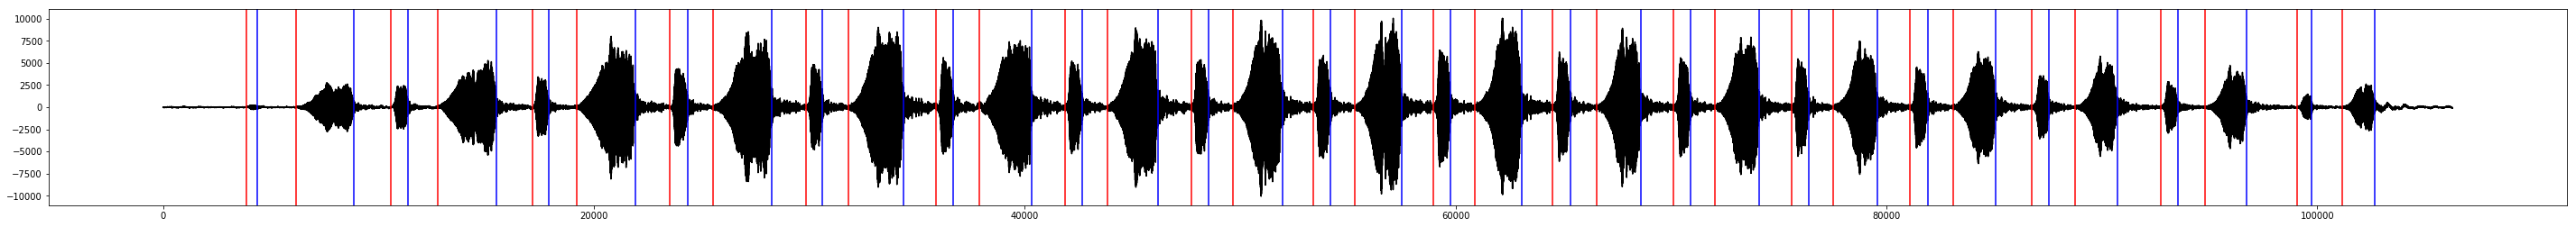

In [44]:
fig, ax = plt.subplots(figsize=(50,4))
plt.plot(wavdata, color='k')
IPython.display.Audio(data=wavdata, rate=row.SAMPLERATE)

for syll_num in range(len(wav_elements.STARTTIME.values)):
    syll_start = ((wav_elements.STARTTIME.values[syll_num]*0.5)/1000)*row.SAMPLERATE
    syll_end = syll_start + ((wav_elements.TIMELENGTH.values[syll_num])/1000)*row.SAMPLERATE

    ax.axvline(syll_start, color='red')
    ax.axvline(syll_end, color = 'blue')

In [55]:
import tensorflow as tf
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix
    
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-40,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=2500,
    mel_upper_edge_hertz=10000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

441.0
88.2


In [56]:
from avgn_paper.signalprocessing import spectrogramming as sg

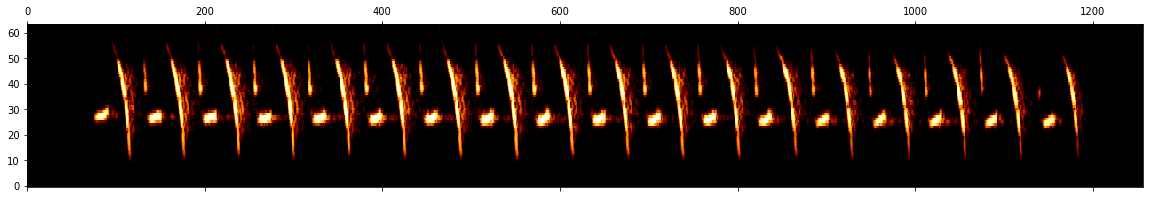

In [61]:
for idx, row in wavs[:50].iterrows():
    wavdata = string2int16(row.WAV)
    spectrogram = sg.spectrogram(int16_to_float32(np.array(wavdata)), hparams)
    mel_spec = np.dot(spectrogram.T, mel_matrix).T
    fig, ax = plt.subplots(ncols = 1, figsize=(20,3))
    #axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    ax.matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    plt.show()
    break

In [ ]:
# get bounding box on frequency (in mel...)